# Выбор локации для скважины

<b> Описание исследования </b>
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

<b>Цель исследования</b>
Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

<b> Задачи исследования</b>

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<b>Данное исследование разделим на несколько частей:</b>

<b> Часть 1. Загрузим и подготовим данные. Поясним порядок действий.</b>

 [ Загрузка и подготовка данных.](#step_1)
 
<b> Часть 2. Обучим и проверим модель для каждого региона:</b>

 [2.1. Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.](#step_2)
 
 [2.2. Обучим модель и сделаем предсказания на валидационной выборке.](#step_3)
 
 [2.3. Сохраним предсказания и правильные ответы на валидационной выборке.](#step_4)
 
 [2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.](#step_5)
 
 [2.5. Проанализируем результаты.](#step_6)
 
 <b> Часть 3. Подготовка к расчёту прибыли</b>

 [3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.](#step_7)
 
 [3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.](#step_8)
  
 [3.3. Напишем выводы по этапу подготовки расчёта прибыли.](#step_9)
 
 <b> Часть 4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:</b>

 [4.1. Выберем скважины с максимальными значениями предсказаний.](#step_10)
 
 [4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.](#step_11)
  
 [4.3. Рассчитаем прибыль для полученного объёма сырья.](#step_12)
   
 <b> Часть 5. Посчитаем риски и прибыль для каждого региона:</b>

 [5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.](#step_13)
 
 [5.2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.](#step_14)
  
 [5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.](#step_15)
 
 <b> [ Чек-лист готовности проекта](#step_16) </b>
 
 

<a id="step_1"></a>
## Загрузка и подготовка данных

Подключим необходимые библиотеки

In [72]:
import matplotlib.pyplot as plt # для расширения работы с графиками
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

warnings.filterwarnings('ignore') # заблокируем предупреждения об ошибках

Загрузим наши данные

In [73]:
try:
    geo_data_0 = pd.read_csv ('geo_data_0.csv')
    geo_data_1 = pd.read_csv ('geo_data_1.csv')
    geo_data_2 = pd.read_csv ('geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv ('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv ('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv ('/datasets/geo_data_2.csv')

In [74]:
# создадим функцию для первичного предпросмотра того, что имеем
def first_look(df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print('------------- Типы данных ------------')
    print(df.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2), '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
        print('------------- Дубликаты ------------')
        if df.duplicated().sum() > 0:
            print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
# ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме 
    min_unique = limit_na_category + 1
    for element in df.columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('------------- Категориальные признаки ------------')
    for element in df.columns:
        if df[element].nunique() <= limit_na_category: 
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )
    print('')
    print('------------- Корреляция в столбцах ------------')
    display(df.corr())
    print('')
    print('------------- Распределение данных ------------')
    df['product'].plot(y='product', kind='hist', bins=20)
    plt.title('Объем запасов в скважинах')
    plt.show()

Посмотрим на наши данные

------------- Первые 5 строк ------------


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------

------------- Категориальные признаки ------------

------------- Корреляция в столбцах ------------


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000



------------- Распределение данных ------------


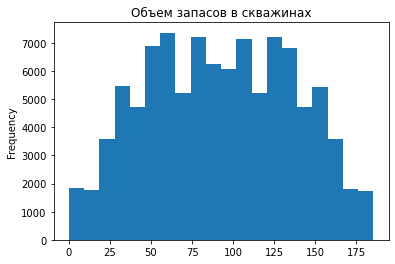

------------- Первые 5 строк ------------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------

------------- Категориальные признаки ------------

------------- Корреляция в столбцах ------------


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000



------------- Распределение данных ------------


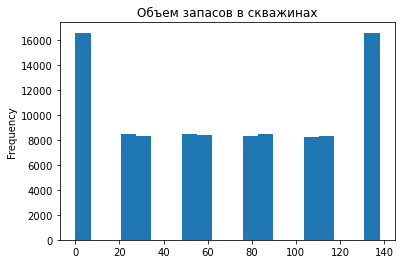

------------- Первые 5 строк ------------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------

------------- Категориальные признаки ------------

------------- Корреляция в столбцах ------------


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000



------------- Распределение данных ------------


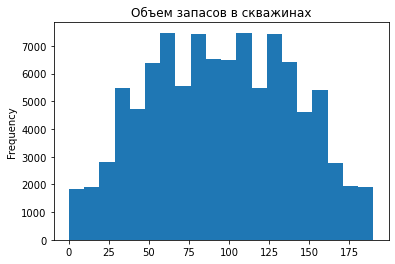

In [75]:
first_look (geo_data_0)
first_look (geo_data_1)
first_look (geo_data_2)

В каждом из датасетов проб трех регионов мы имеем по 100000 значений:

•	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

•	product — объём запасов в скважине (тыс. баррелей).


Данные по второму региону сильно скоррелированы, бросается в глаза почти абсолютная корреляция признака 'f2' отнотильно 'product'. Рассмотрим данный регион внимательнее.

In [76]:
display(geo_data_1['f2'].unique())
geo_data_1.nunique()

array([-5.87601369e-03,  9.99182737e-01,  5.00116016e+00, ...,
        4.99865060e+00,  1.00014635e+00, -3.29851829e-03])

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

Во втором регионе либо данные потеряли, либо что-то произошло с ними, но факт на лицо - всего 12 уникальных значений. Можно предположить, что по всему региону запасы зависят только от даных по столбцу 'f2'. В любом случае необходимо обратить на это внимание. Если с данными что-то не так и это подтвердится, необходимо восстановить (дополнить) их и пересчитать все заново с вновь открывшимися обстоятельствами.

## Обучение и проверка модели

<a id="step_2"></a>
2.1. Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [77]:
# создадим функцию разбивки данных с необходимыми нам условиями:
def df_split(df:pd.DataFrame) -> pd.array:
    features = df.drop(['id', 'product'] , axis=1)
    target = df['product']

    features_train, features_valid, target_train, target_valid=train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    return features_train, features_valid, target_train, target_valid

In [78]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = df_split(geo_data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = df_split(geo_data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = df_split(geo_data_2)

<a id="step_3"></a>
2.2. Обучим модель и сделаем предсказания на валидационной выборке.

In [79]:
# обучение модели будем производить на модели линейной регриссии
model = LinearRegression()
# создадим функцию обучения модели и предсказаний
def model_predict(features_train: pd.array,
                  features_valid: pd.array,
                  target_train: pd.array,
                  target_valid: pd.array):
                
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    df_dict = {'real_product':target_valid, # реальные данные по объему запасов
            'predicted_product':predicted_target # предсказания по объему запасов
    }
    df_frame = pd.DataFrame(df_dict, columns=['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target) ** 0.5
    mean = df_frame['predicted_product'].mean()
    product_sum = df_frame['predicted_product'].sum()
    return df_frame, rmse, mean, product_sum

In [80]:
df_frame_0, rmse_0, mean_0, product_sum_0 = model_predict(features_train_0,
                                                          features_valid_0,
                                                          target_train_0,
                                                          target_valid_0)
df_frame_1, rmse_1, mean_1, product_sum_1 = model_predict(features_train_1,
                                                          features_valid_1,
                                                          target_train_1,
                                                          target_valid_1)
df_frame_2, rmse_2, mean_2, product_sum_2 = model_predict(features_train_2,
                                                          features_valid_2,
                                                          target_train_2,
                                                          target_valid_2)

<a id="step_4"></a>
2.3. Сохраним предсказания и правильные ответы на валидационной выборке.

In [81]:
display(df_frame_0.head())
display(df_frame_1.head())
display(df_frame_2.head())

,real_product,predicted_product
71751,10.038645,95.894952
80493,114.551489,77.572583
2655,132.603635,77.892640
53233,169.072125,90.175134
91141,122.325180,70.510088


,real_product,predicted_product
71751,80.859783,82.663314
80493,53.906522,54.431786
2655,30.132364,29.748760
53233,53.906522,53.552133
91141,0.000000,1.243856


,real_product,predicted_product
71751,61.212375,93.599633
80493,41.850118,75.105159
2655,57.776581,90.066809
53233,100.053761,105.162375
91141,109.897122,115.303310


<a id="step_5"></a>
2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

In [82]:
print('Средний запас предсказанного сырья в скважинах первого региона:', mean_0, 'при RMSE:', rmse_0)
print('Средний запас предсказанного сырья в скважинах второго региона:', mean_1, 'при RMSE:', rmse_1)
print('Средний запас предсказанного сырья в скважинах третьего региона:', mean_2, 'при RMSE:', rmse_2)

Средний запас предсказанного сырья в скважинах первого региона: 92.59256778438035 при RMSE: 37.5794217150813
Средний запас предсказанного сырья в скважинах второго региона: 68.72854689544602 при RMSE: 0.893099286775617
Средний запас предсказанного сырья в скважинах третьего региона: 94.96504596800489 при RMSE: 40.02970873393434


<a id="step_6"></a>
2.5. Проанализируем результаты.

При обучении модель лучше всего обучилась на выборке по второму региону, но средние запасы предсказанного сырья во втором регионе ниже, чем в первом и в третьем.

## Подготовка к расчёту прибыли

<a id="step_7"></a>
3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.

In [83]:
# количество исследуемых скважин в регионе
drilling_well=500

# количество лучших для разработки скважин
best_drilling_well=200

# бюджет на разработку скважин в регионе
budget=10000000000

# доход с каждой единицы продукта
income=450000

# риск убытков
risk=0.025

# количество выборок
bootstrap=1000

<a id="step_8"></a>
3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [84]:
# минимальный безубыточный объем добычи сырья одной скважиной будет равен затратам на разработку
# одной скважины деленной на доход с каждой единицы продукта с учетом риска
print(((budget / best_drilling_well) / income) * (1 - risk))

108.33333333333333


Исходя из полученных ранее средних запасов предсказанного сырья в скважинах первого, второго и третьего регионов, мы видим, что на скважинах ни одного региона мы не получим безубыточной добычи.

<a id="step_9"></a>
3.3. Напишем выводы по этапу подготовки расчёта прибыли.

In [85]:
# напишем функцию для предсказания среднего запаса сырья в скважине по регионам в best_drilling_well
# лучших по добыче скважинах
def prediction(df: pd.DataFrame)-> pd.Series:
    predicted = pd.Series(df['predicted_product']).reset_index(drop=True)
    predicted_sorted = predicted.sort_values(ascending=False)
    selected = predicted_sorted.loc[:best_drilling_well]
    return selected

In [86]:
print('Запас предсказанного сырья в скважинах первого региона:', prediction(df_frame_0).mean())
print('Запас предсказанного сырья в скважинах второго региона:', prediction(df_frame_1).mean())
print('Запас предсказанного сырья в скважинах третьего региона:', prediction(df_frame_2).mean())

Запас предсказанного сырья в скважинах первого региона: 153.88877619656222
Запас предсказанного сырья в скважинах второго региона: 137.04671812922754
Запас предсказанного сырья в скважинах третьего региона: 100.14074839779047


При выборе 200 лучших по добыче скважин мы видим, что скважины уже не такие убыточные, вышли в плюс по окупаемости разведки и последубщей добычи.

В лидерах первый регион, за ним с небольшим отставание второй, аутсайдер - третий регион, который не вышел на уровень окупаемости.

Тем самым мы видим, что при выборе 200 самых прибыльных скважин, мы можем добиться более весомых результатов.

Нам необходимо в дальнейшем убедиться, что при рекомендации региона для разработки и выборе 200 лучших скважин наш выбор будет отправдан и предприятие безубыточное.

## Расчёт прибыли и рисков 

<a id="step_10"></a>
4.1. Выберем скважины с максимальными значениями предсказаний.

In [87]:
# заполним данные по скважинам с максимальными значениями предсказаний по добыче
best_predicted_df_frame_0  = prediction(df_frame_0)
best_predicted_df_frame_1  = prediction(df_frame_1)
best_predicted_df_frame_2  = prediction(df_frame_2)

display(best_predicted_df_frame_0.head())
display(best_predicted_df_frame_1.head())
display(best_predicted_df_frame_2.head())

9317     180.180713
219      176.252213
10015    175.850623
11584    175.658429
23388    173.299686
Name: predicted_product, dtype: float64

20430    139.818970
7777     139.773423
8755     139.703330
1178     139.560938
4285     139.516754
Name: predicted_product, dtype: float64

22636    165.856833
24690    165.679685
7811     163.439962
1581     162.062589
6751     161.797476
Name: predicted_product, dtype: float64

<a id="step_11"></a>
4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.

In [88]:
volum_best_predicted_df_frame_0 = best_predicted_df_frame_0.sum()
volum_best_predicted_df_frame_1 = best_predicted_df_frame_1.sum()
volum_best_predicted_df_frame_2 = best_predicted_df_frame_2.sum()

In [89]:
print('В первом регионе мы получим', volum_best_predicted_df_frame_0, 'тыс. баррелей')
print('Во втором регионе мы получим', volum_best_predicted_df_frame_1, 'тыс. баррелей')
print('В ьретьем регионе мы получим', volum_best_predicted_df_frame_2, 'тыс. баррелей')

В первом регионе мы получим 38472.194049140555 тыс. баррелей
Во втором регионе мы получим 397435.48257475987 тыс. баррелей
В ьретьем регионе мы получим 2149521.1643585726 тыс. баррелей


<a id="step_12"></a>
4.3. Рассчитаем прибыль для полученного объёма сырья.

In [90]:
income_best_predicted_df_frame_0 = volum_best_predicted_df_frame_0 * income
income_best_predicted_df_frame_1 = volum_best_predicted_df_frame_1 * income
income_best_predicted_df_frame_2 = volum_best_predicted_df_frame_2 * income

In [91]:
print('В первом регионе мы получим', income_best_predicted_df_frame_0 / 1000000, 'млн. рублей прибыли')
print('Во втором регионе мы получим', income_best_predicted_df_frame_1 / 1000000, 'млн. рублей прибыли')
print('В третьем регионе мы получим', income_best_predicted_df_frame_2 / 1000000, 'млн. рублей прибыли')

В первом регионе мы получим 17312.48732211325 млн. рублей прибыли
Во втором регионе мы получим 178845.96715864193 млн. рублей прибыли
В третьем регионе мы получим 967284.5239613577 млн. рублей прибыли


По расчитанной прибыли для полученного объема предсказаний можно сделать вывод о том, что скважины во втором и теретьем регионе выходят за грань нерентабельности, а первого - нет

## Посчитаем риски и прибыль для каждого региона:

<a id="step_13"></a>
5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [92]:
# напишем функцию расчета выручки
def revenue(target: pd.Series, probabilities: pd.Series)-> float:
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:best_drilling_well]
    return (income * selected.sum()) / 1000000

In [93]:
# создадим функцию для расчета средней выручки по региону
def revenue_region(df: pd.DataFrame):
    count=0
    state=np.random.RandomState(12345)
    values=[]
    for i in range(bootstrap):
        target_subsample = df['real_product'].sample(drilling_well, replace=True, random_state=state)
        probs_subsample = df['predicted_product'][target_subsample.index]
        value = revenue(target_subsample, probs_subsample)
        values.append(value)
        if (value - (budget / 1000000)) < 0:
            count += 1
    values = pd.Series(values)
    mean = values.mean()
    
    confidence_interval = st.t.interval((1 - risk * 2), len(values) - 1, values.mean(), values.sem())
     
    pvalue = 1 * count / 1000
    income_df = mean - budget / 1000000

    
    return mean, confidence_interval, pvalue, income_df

In [94]:
mean_revenue_region_0, confidence_interval_0, pvalue_0, income_region_0 = revenue_region(df_frame_0)
print('Средняя выручка первого региона', mean_revenue_region_0, 'млн. рублей')
mean_revenue_region_1, confidence_interval_1, pvalue_1, income_region_1 = revenue_region(df_frame_1)
print('Средняя выручка второго региона', mean_revenue_region_1, 'млн. рублей')
mean_revenue_region_2, confidence_interval_2, pvalue_2, income_region_2 = revenue_region(df_frame_2)
print('Средняя выручка третьего региона', mean_revenue_region_2, 'млн. рублей')

Средняя выручка первого региона 10425.938526910591 млн. рублей
Средняя выручка второго региона 10515.222773443289 млн. рублей
Средняя выручка третьего региона 10435.008362782757 млн. рублей


<a id="step_14"></a>
5.2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [95]:
print('Средняя прибыль первого региона', income_region_0, 'млн. рублей')
print('95%-й доверительный интервал первого региона', confidence_interval_0)
print('Вероятность убытков равна', pvalue_0, 'при допустимом', risk)
print('')
print('Средняя прибыль второго региона', income_region_1, 'млн. рублей')
print('95%-й доверительный интервал второго региона', confidence_interval_1)
print('Вероятность убытков равна', pvalue_1, 'при допустимом', risk)
print('')
print('Средняя прибыль третьего региона', income_region_2, 'млн. рублей')
print('95%-й доверительный интервал третьего региона', confidence_interval_2)
print('Вероятность убытков равна', pvalue_2, 'при допустимом', risk)

Средняя прибыль первого региона 425.93852691059146 млн. рублей
95%-й доверительный интервал первого региона (10408.732207068697, 10443.144846752486)
Вероятность убытков равна 0.06 при допустимом 0.025

Средняя прибыль второго региона 515.222773443289 млн. рублей
95%-й доверительный интервал второго региона (10501.62147617632, 10528.824070710258)
Вероятность убытков равна 0.01 при допустимом 0.025

Средняя прибыль третьего региона 435.0083627827571 млн. рублей
95%-й доверительный интервал третьего региона (10417.45355204136, 10452.563173524155)
Вероятность убытков равна 0.064 при допустимом 0.025


<a id="step_15"></a>
5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.

На основании проведеного анализа мы видим, что все 3 региона являются прибыльными, но при выборе 200 лучших скважин вероятность убытков в первом и третьем регионе высока относительно принятой в условии задания.

Нам остается рекомендовать заказчику для разработки только регион №2.

In [96]:
# создадим функцию для расчета средней выручки по региону
def revenue_region (df: pd.DataFrame):
    count = 0
    state = np.random.RandomState (12345)
    values = []
    income_df = []
    for i in range(bootstrap):
        target_subsample = df['real_product'].sample(drilling_well, replace=True, random_state=state)
        probs_subsample = df['predicted_product'][target_subsample.index]
        value = revenue(target_subsample, probs_subsample)
        income_moment = value - budget / 1000000
        values.append(value)
        income_df.append(income_moment)
        if (value - (budget / 1000000)) < 0:
            count += 1
    values = pd.Series(values)
    income_df = pd.Series(income_df)
    mean = values.mean()
    
    confidence_interval = (income_df.quantile(risk), income_df.quantile(1 - risk))     
    
    pvalue = 1 * count / 1000
    income_mean = mean - budget / 1000000
    
    # построим распределение выручки по региону
    plt.figure()
    plt.hist(income_df,  bins=100)
    
    # левая граница доверительного интервала
    min_x, min_y = [confidence_interval[0], confidence_interval[0]], [0, 30]
    # правая граница доверительного интервала
    max_x, max_y = [confidence_interval[1], confidence_interval[1]], [0, 30]
    plt.title('Гистограмма распределения прибыли')
    plt.xlabel('Прибыль в млн. рублей')
    plt.plot(min_x, min_y, max_x, max_y, marker = 'o')
    plt.show()
    
    return mean, confidence_interval, pvalue, income_mean

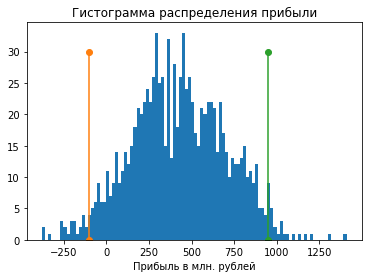

Средняя выручка первого региона 10425.938526910591 млн. рублей
Средняя прибыль первого региона 425.93852691059146 млн. рублей
95%-й доверительный интервал первого региона (-102.09009483793598, 947.976353358369)
Вероятность убытков равна 0.06 при допустимом 0.025



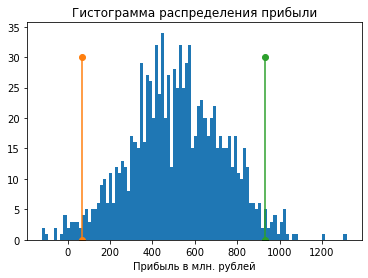

Средняя выручка второго региона 10515.222773443289 млн. рублей
Средняя прибыль второго региона 515.222773443289 млн. рублей
95%-й доверительный интервал второго региона (68.87322537050254, 931.547591257049)
Вероятность убытков равна 0.01 при допустимом 0.025



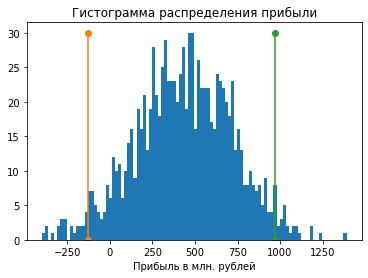

Средняя выручка третьего региона 10435.008362782757 млн. рублей
Средняя прибыль третьего региона 435.0083627827571 млн. рублей
95%-й доверительный интервал третьего региона (-128.88054732978893, 969.7069541802657)
Вероятность убытков равна 0.064 при допустимом 0.025


In [97]:
mean_revenue_region_0, confidence_interval_0, pvalue_0, income_region_0 = revenue_region(df_frame_0)
print('Средняя выручка первого региона', mean_revenue_region_0, 'млн. рублей')
print('Средняя прибыль первого региона', income_region_0, 'млн. рублей')
print('95%-й доверительный интервал первого региона', confidence_interval_0)
print('Вероятность убытков равна', pvalue_0, 'при допустимом', risk)
print('')
mean_revenue_region_1, confidence_interval_1, pvalue_1, income_region_1 = revenue_region(df_frame_1)
print('Средняя выручка второго региона', mean_revenue_region_1, 'млн. рублей')
print('Средняя прибыль второго региона', income_region_1, 'млн. рублей')
print('95%-й доверительный интервал второго региона', confidence_interval_1)
print('Вероятность убытков равна', pvalue_1, 'при допустимом', risk)
print('')
mean_revenue_region_2, confidence_interval_2, pvalue_2, income_region_2 = revenue_region(df_frame_2)
print('Средняя выручка третьего региона', mean_revenue_region_2, 'млн. рублей')
print('Средняя прибыль третьего региона', income_region_2, 'млн. рублей')
print('95%-й доверительный интервал третьего региона', confidence_interval_2)
print('Вероятность убытков равна', pvalue_2, 'при допустимом', risk)

<a id="step_16"></a>
## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован